In [39]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import time 
from statistics import mean

In [40]:
train = pd.read_csv("../input/intro2ml-kpfu-1/train.csv")
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [41]:
h_sales= train[['SalePrice','GrLivArea','1stFlrSF','TotalBsmtSF','YearBuilt','GarageArea','WoodDeckSF','2ndFlrSF',]].fillna (0)
# h_sales.head()

In [42]:
n = len(h_sales)
# n - количество объектов
m = len(h_sales.drop('SalePrice', axis=1).columns)
# m - количество признаков(колонок)
y = h_sales['SalePrice'].values.reshape((n, 1)) #транспонируем строку(массив) с ценами
X = h_sales.drop('SalePrice',  axis=1).values.reshape((n, m))


In [43]:
X = np.hstack((np.ones((n, 1)), X)) #расширим матрицу признаков сложив с единичной

In [44]:
def compute_loss(y, tx, w, flag=0):
    """Функция потерь"""
    # w = [1, 2].transpose()

    e = y -np.dot(tx, w)

    if(flag == 0):
        loss_result_mse = 0.5 * np.mean(e**2) #квадратичная 
        return loss_result_mse
    
    else:
        loss_result_mae = 0.5 * np.mean(np.abs(e)) #по модулю
        return loss_result_mae
    

# 1 Линейная регрессия по заданному количе- ству признаков

In [45]:
def compute_gradient(y, tx, w):
    """Вычислить градиент."""
    
    
    e = y - np.dot(tx, w)
    #print(e)
    N = np.shape(y)[0]
    
    # Среднеквадратическая ошибка
    gradient_mse = (-1/N) * np.dot(tx.T, e)
    return gradient_mse
    
    '''
    # Средняя абсолютная ошибка
    gradient_mae = (-1/N) * np.dot(tx.T, e)
    return gradient_mae
    '''
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """Алгоритм градиентного спуска."""
    
    ws = [initial_w]
    losses = []
    w = initial_w
    global_epsilon = 0.18*1e10 
    iterat = 0
    for n_iter in range(0,max_iters):
        
        loss = compute_loss(y, tx, w)
        grad = compute_gradient(y, tx, w)
        w = w - gamma * grad  #обновляем веса
        # сохраняем w and loss
        ws.append(w)
        losses.append(loss)
#         if(  (n_iter != 0)  and   ( abs(losses[n_iter]) >= (losses[n_iter-1])) ):
#             iterat = n_iter
#             break
#         print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
#                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
#     print(iterat)
    return losses, ws[iterat-1]

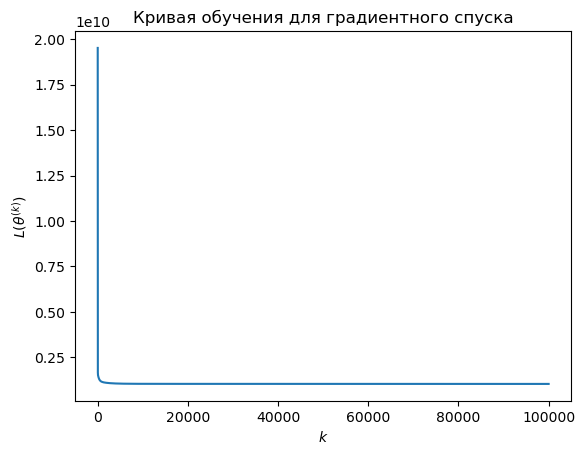

In [46]:
# градиентный спуск
theta_0 = np.zeros((m + 1, 1))
loss_history_grad, theta_best_grad = gradient_descent(y, X, theta_0, gamma=9e-9, max_iters= 100000)

plt.plot(loss_history_grad)
plt.xlabel('$k$')
plt.ylabel('$L(\\theta^{(k)})$')
_ = plt.title('Кривая обучения для градиентного спуска')

In [47]:
compute_loss(y, X,  theta_best_grad)

1033444281.8402159

# 2 Стохастический градиентный спуск

In [48]:
def batch_iter(y, tx, batch_size, num_batches=1, shuffle=True):
    """
    Создайте мини-итератор для набора данных.
    На вход пподаются два набора данных y, tx
    На выходе y, tx с нужными размерами
    Данные можно перемешивать случайным образом, 
    чтобы избежать упорядочения исходных данных и случайности.
    
    
    """
    data_size = len(y) #10000
    
    # перемешать
    if shuffle:
        # np.random.permutation Генерировать случайную последовательность чисел
        # shuffle_indices предназначен для генерации последовательности случайных чисел  0-9999.
        shuffle_indices = np.random.permutation(np.arange(data_size))
        # y и tx - исходная последовательность, но порядок нарушен
        shuffled_y = y[shuffle_indices]
        shuffled_tx = tx[shuffle_indices]
    # сохранить первоначальный порядок
    else:
        shuffled_y = y
        shuffled_tx = tx
        
    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, data_size)
        if start_index != end_index:
            # yield можно понимать как return，Но в следующий раз программа снова запустится отсюда.
            yield shuffled_y[start_index:end_index], shuffled_tx[start_index:end_index]

In [49]:
def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """Алгоритм стохастического градиентного спуска."""
   
    ws = [initial_w]
    losses = []
    w = initial_w
    global_epsilon = 0.18*1e10 
    iterat = 0
    # def batch_iter(y, tx, batch_size, num_batches=1, shuffle=True)
    for n_iter in range(max_iters):
        for y_batch, tx_batch in batch_iter(y, tx, batch_size = batch_size):
            loss = compute_loss(y, tx, w)
            grad = compute_gradient(y_batch, tx_batch, w)
            w = w - gamma * grad
            ws.append(w)
            losses.append(loss)
        if(abs(losses[n_iter]) <= global_epsilon):
            iterat = n_iter
            break
            
            #print("Stochastic Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    
    #raise NotImplementedError
#     print(iterat)
#     print( losses.index(min(losses)))
    return losses, ws[iterat-1], iterat

Text(0.5, 1.0, 'График функции потерь')

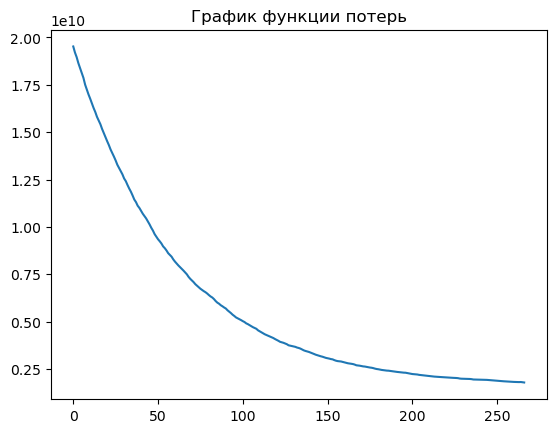

In [50]:
#стохастический
theta_0 = np.zeros((m + 1, 1))
loss_history_stoch, theta_best_stoch, iteraa = stochastic_gradient_descent(y, X, theta_0,gamma=9e-10, max_iters= 10000,batch_size =20)
plt.plot(loss_history_stoch)
plt.title('График функции потерь')



In [51]:
compute_loss(y, X, theta_best_stoch)

1808429341.553733

# 3 Размера батча и SGD

In [52]:
def size_sgd(batch_size_):
    time_k = []
    
    start = time.time() ## точка отсчета времени
    loss_history, theta_best, itr = stochastic_gradient_descent(y, X, theta_0,gamma=1e-10, 
                                                                max_iters= 10000,batch_size = batch_size_ )
    end = (time.time() - start) ## собственно время работы программы
    time_k.append(end)
    time_k_mean = mean(time_k)

    return itr, time_k_mean

In [53]:
colshag = []
batchsize = []
timebatch = []
for i in range(10,1000, 10):
    itern_k, nmean = size_sgd(i)
    colshag.append(itern_k)
    batchsize.append(i)
    timebatch.append(nmean)
    

Text(0.5, 1.0, 'График зависимости количества шагов до сходимости от размера батча')

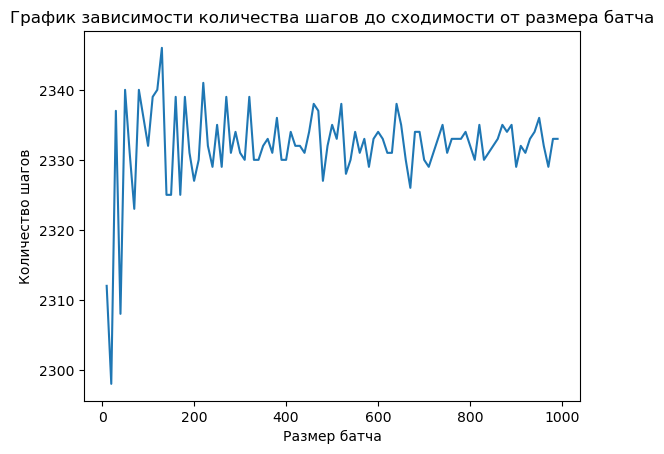

In [54]:
plt.plot(batchsize,colshag)
plt.xlabel('Размер батча')
plt.ylabel('Количество шагов')
plt.title('График зависимости количества шагов до сходимости от размера батча')

Text(0.5, 1.0, 'График зависимости времени до сходимости от размера батча.')

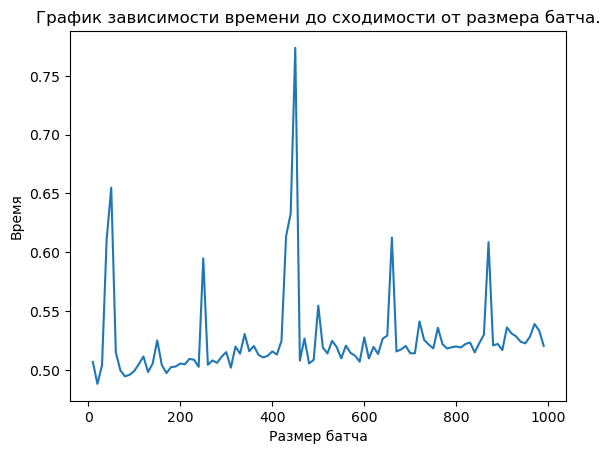

In [55]:
plt.plot(batchsize,timebatch)
plt.xlabel('Размер батча')
plt.ylabel('Время')
plt.title('График зависимости времени до сходимости от размера батча.')

# 4 Импульсный градиентный спуск

In [56]:
def gradient_descent_m(y, tx, initial_w, max_iters, gamma, moment):
    """Алгоритм градиентного спуска."""
    
    ws = [initial_w]
    losses = []
    w = initial_w
    global_epsilon = 0.18*1e10 
    iterat = 0
    #1 iter
    tv_grad = 0
    
    
    for n_iter in range(0,max_iters):
        
        loss = compute_loss(y, tx, w)
        grad = compute_gradient(y, tx, w)
        tv = moment*tv_grad +(1-moment)*grad 
        w = w - gamma *tv   #обновляем веса
        tv_grad = compute_gradient(y, tx, w)
        # сохраняем w and loss
        ws.append(w)
        losses.append(loss)
        if(abs(losses[n_iter]) <= global_epsilon):
            iterat = n_iter
#             break
#         print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
#                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
#     print(iterat)
    return losses, ws[iterat-1]

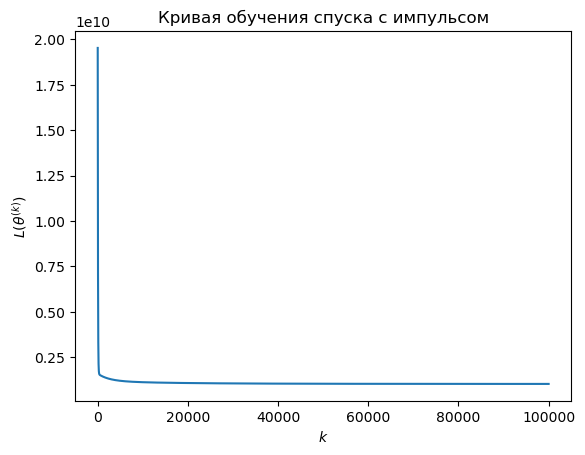

In [57]:
loss_history_moment, theta_best_moment= gradient_descent_m(y, X, theta_0,gamma=1e-9, max_iters= 100000, moment =0.9)
plt.plot(loss_history_moment)
plt.xlabel('$k$')
plt.ylabel('$L(\\theta^{(k)})$')
_ = plt.title('Кривая обучения спуска с импульсом')

In [58]:
compute_loss(y, X, theta_best_moment) 


1037985132.3351984

# 5 Сравнение методов градиентного спуска

Text(0, 0.5, '$L(\\theta^{(k)})$')

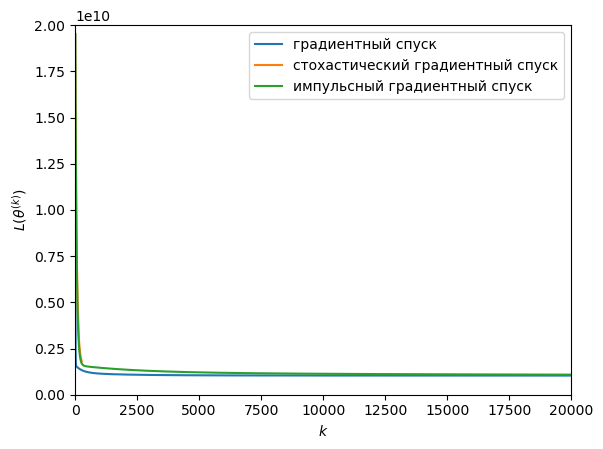

In [59]:



plt.plot(loss_history_grad )

plt.plot(loss_history_stoch)

plt.plot(loss_history_moment)
plt.legend(['градиентный спуск','стохастический градиентный спуск','импульсный градиентный спуск', ])
plt.axis([0.0, 20000, 0, 2e10])
plt.xlabel('$k$')
plt.ylabel('$L(\\theta^{(k)})$')

# 6 Перестановочная важность признака

In [60]:
test = pd.read_csv("../input/intro2ml-kpfu-1/test.csv")
h_testfirst= test[['Id','GrLivArea','1stFlrSF','TotalBsmtSF','YearBuilt','GarageArea','WoodDeckSF','2ndFlrSF',]].fillna (0)
h_test= test[['GrLivArea','1stFlrSF','TotalBsmtSF','YearBuilt','GarageArea','WoodDeckSF','2ndFlrSF',]].fillna (0)
h_test.head()

,GrLivArea,1stFlrSF,TotalBsmtSF,YearBuilt,GarageArea,WoodDeckSF,2ndFlrSF
0,896,896,882.0,1961,730.0,140,0
1,1329,1329,1329.0,1958,312.0,393,0
2,1629,928,928.0,1997,482.0,212,701
3,1604,926,926.0,1998,470.0,360,678
4,1280,1280,1280.0,1992,506.0,0,0


In [61]:
n_test = len(h_test)
# n - количество объектов
m_test = len(h_test.columns)
# m - количество признаков(колонок)
X_test = h_test.values.reshape((n_test, m_test)) #нам тестовый набор для проверки обученной модели
X_test = np.hstack((np.ones((n_test, 1)), X_test)) #расширим матрицу признаков сложив с единичной

In [62]:
Y_test = X_test.dot(theta_best_grad) # Предсказание на тренировочных данных 
len(Y_test)

Y_test = np.array(Y_test)
Y_test= Y_test.flatten().tolist ()
Y_test = np.array(Y_test)
Y_test

array([160490.99762626, 183338.17024853, 192701.94462466, ...,
       202494.15922998,  90643.98700473, 236419.28760236])

In [63]:
solution = pd.DataFrame({"id":h_testfirst['Id'].values, "SalePrice":Y_test})
solution

,id,SalePrice
0,1461,160490.997626
1,1462,183338.170249
2,1463,192701.944625
3,1464,198559.011382
4,1465,173154.511756
...,...,...
1454,2915,79699.881192
1455,2916,107854.872396
1456,2917,202494.159230
1457,2918,90643.987005


In [64]:
solution.to_csv("submission.csv", index = False)